# Laboratoire 3 : Machines à vecteurs de support et réseaux neuronaux
#### Département du génie logiciel et des technologies de l’information

| Étudiants             |                                                         |
|-----------------------|---------------------------------------------------------|
| Jean-Philippe Decoste |  DECJ19059105                                           |
| Ahmad Al-Taher        |   ALTA22109307                                          |
| Stéphanie Lacerte     |   LACS06629109                                          |
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | Automne 2018                                            |
| Groupe                | 2                                                       |
| Numéro du laboratoire | 02                                                      |
| Professeur            | Hervé Lombaert                                          |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 30 oct 2018                                             |

In [7]:
import csv
import math
import os

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from tabulate import tabulate
import matplotlib.pyplot as plt

from helpers import utilities as Utils
from helpers import datasets as Data

## Paramètres

In [ ]:
#MERGED_GALAXY_PRIMITIVE = r"data\csv\eq07_pMerged.csv"
ALL_GALAXY_PRIMITIVE = r"data\csv\galaxy\galaxy_feature_vectors.csv"
MERGED_GALAXY_PRIMITIVE = r".\galaxies.csv"

# Neural Network
LAYERS_ACTIVATION = 'relu'
LAST_LAYER_ACTIVATION = 'sigmoid'
TENSORBOARD_SUMMARY = r"tensorboard"

## SVM

In [16]:
def svm():    
    #linear    
    print("SVM linear")
    c=[0.001,0.1,1.0,10.0]
    params = dict(kernel=['linear'], C=c ,class_weight=['balanced'], cache_size=[2048])
    grid = GridSearchCV(SVC(), param_grid=params, cv=dataset_splitter, n_jobs=-1, iid=True)
    
    #Fit the feature to svm algo
    grid.fit(features_SVM, answers)
    
    #build table
    outPut = []
    y1 = []
    for i in range(0, 4):
        outPut.append([grid.cv_results_['params'][i]['C'],
                          "{0:.2f}%".format(grid.cv_results_['mean_test_score'][i]*100)])
        y1.append(grid.cv_results_['mean_test_score'][i]*100)
    
    #print table
    print(tabulate(outPut, headers=['Variable C','class_weight= {‘balanced’}']))
    print("The best parameters are ", grid.best_params_," with a score of {0:.2f}%".format(float(grid.best_score_)* 100))
    
    #rbf
    print("\nSVM rbf")
    params = dict(kernel=['rbf'], C=c, gamma=c ,class_weight=['balanced'], cache_size=[2048])
    grid = GridSearchCV(SVC(), param_grid=params, cv=dataset_splitter, n_jobs=-1, iid=True)
    
    #Fit the feature to svm algo
    grid.fit(features_SVM, answers)
    
    #build table
    outPut = []
    outPut.append(['0.001',
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][0]*100),
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][1]*100),
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][2]*100),
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][3]*100)])
    outPut.append(['0.1',
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][4]*100),
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][5]*100),
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][6]*100),
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][7]*100)])
    outPut.append(['1.0',
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][8]*100),
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][9]*100),
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][10]*100),
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][11]*100)])
    outPut.append(['10.0',
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][12]*100),
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][13]*100),
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][14]*100),
                   "{0:.2f}%".format(grid.cv_results_['mean_test_score'][15]*100)])
    y2=[grid.cv_results_['mean_test_score'][0]*100,grid.cv_results_['mean_test_score'][1]*100,grid.cv_results_['mean_test_score'][2]*100,grid.cv_results_['mean_test_score'][3]*100]
    y3=[grid.cv_results_['mean_test_score'][4]*100,grid.cv_results_['mean_test_score'][5]*100,grid.cv_results_['mean_test_score'][6]*100,grid.cv_results_['mean_test_score'][7]*100]
    y4=[grid.cv_results_['mean_test_score'][8]*100,grid.cv_results_['mean_test_score'][9]*100,grid.cv_results_['mean_test_score'][10]*100,grid.cv_results_['mean_test_score'][11]*100]
    y5=[grid.cv_results_['mean_test_score'][12]*100,grid.cv_results_['mean_test_score'][13]*100,grid.cv_results_['mean_test_score'][14]*100,grid.cv_results_['mean_test_score'][15]*100]
    #print table
    print(tabulate(outPut, headers=['Variable C','Ɣ=0.001','Ɣ=0.1','Ɣ=1.0','Ɣ=10.0']))
    print("The best parameters are ", grid.best_params_," with a score of {0:.2f}%".format(float(grid.best_score_)* 100))
    
    print("-> Done\n\n")
    
    plt.grid(True) 
    plt.xlabel('Variable C')
    plt.ylabel('Accuracy')
    
    plt.plot(c, y1,label='Linear')
    plt.plot(c, y2,label='Gamma=0.001')
    plt.plot(c, y3,label='Gamma=0.1')
    plt.plot(c, y4,label='Gamma=1')
    plt.plot(c, y5,label='Gamma=10')
    plt.legend()
    plt.ylim(45, 85)
    plt.show()

## Réseaux neuronaux

In [ ]:
def neuralNetwork(runId, networkFrame, epoch, learning_rate):
    # Format arrays to np arrays
    features_train = []
    answers_train = []
    features_test = []
    answers_test = []

    for train_index, test_index in dataset_splitter.split(features, answers):
        for elem in train_index:
            features_train.append(features[elem])
            answers_train.append(answers[elem])

        for elem in test_index:
            features_test.append(features[elem])
            answers_test.append(answers[elem])

    print("1.Initializing Neural Network for run #" + str(runId))

    # Create a default in-process session.
    directory = TENSORBOARD_SUMMARY + "/run" + str(runId)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print("TensorBoard summary writer at :" + directory + "\n")
    tbCallBack = keras.callbacks.TensorBoard(log_dir=directory, histogram_freq=1, write_graph=False, write_images=False)
    
    # Parameters
    dimension = len(features[0])
    layers = networkFrame
    epoch = epoch
    batch_size = 200
    learning_rate = learning_rate
    
    # The network type
    neuralNetwork_model = keras.Sequential()
    counter = 1

    # Set layer in model
    # First layer is set according to data dimension
    neuralNetwork_model.add(keras.layers.Dense(dimension, input_dim=dimension, kernel_initializer='random_normal', bias_initializer='zeros', activation=LAYERS_ACTIVATION))
    neuralNetwork_model.add(keras.layers.Dropout(0.5))
    # Other layer set using layers array
    for perceptron in layers:
        if len(layers) == counter:
            # Last layer (2 neurons for 2 possible class, SIGMOID ensure result between 1 and 0)
            neuralNetwork_model.add(keras.layers.Dense(1, kernel_initializer='random_normal', bias_initializer='zeros', activation=LAST_LAYER_ACTIVATION))
            #print("Layer #" + str(counter) + ": dimension = " + str(2) + ", activation = " + LAST_LAYER_ACTIVATION)
        else:
            # Adds Layer
            neuralNetwork_model.add(keras.layers.Dense(perceptron, kernel_initializer='random_normal', bias_initializer='zeros', activation=LAYERS_ACTIVATION))
            neuralNetwork_model.add(keras.layers.Dropout(0.5))
            #print("Layer #" + str(counter) + ": dimension = " + str(perceptron) + ", activation = " + LAYERS_ACTIVATION)
        counter = counter + 1

    # Compile the network according to previous settings
    neuralNetwork_model.compile(optimizer=tf.train.AdamOptimizer(learning_rate), 
                                loss='binary_crossentropy', 
                                metrics=['accuracy'])

    # Print visualisation of network (layer and perceptron)
    neuralNetwork_model.summary()

    # Fit model to data
    print("\n2.Training\n")
    neuralNetwork_model.fit(np.array(features_train), np.array(answers_train), 
                            epochs=epoch, 
                            batch_size=batch_size, 
                            validation_data=(np.array(features_test), np.array(answers_test)),
                            callbacks=[tbCallBack], 
                            verbose=2)

    # Evaluation
    #scores = neuralNetwork_model.evaluate(np.array(features_train), np.array(answers_train), verbose=1)
    #print("\n%s: %.2f%%" % (neuralNetwork_model.metrics_names[1], scores[1]*100))

    # Clear previous model
    keras.backend.clear_session()

## Main

PREPARING DATASETS
Reading Galaxy features:
Progress |**************************************************| 100.0% Complete
-> Done

Splitting Dataset according to these params:
Property        Value
------------  -------
n_splits          5
test_size         0.2
random_state      0
-> Done


ALGORITHMS

SVM:
SVM linear
  Variable C  class_weight= {‘balanced’}
------------  ----------------------------
       0.001  51.89%
       0.1    77.97%
       1      81.28%
      10      81.43%
The best parameters are  {'C': 10.0, 'cache_size': 2048, 'class_weight': 'balanced', 'kernel': 'linear'}  with a score of 81.43%

SVM rbf
  Variable C  Ɣ=0.001    Ɣ=0.1    Ɣ=1.0    Ɣ=10.0
------------  ---------  -------  -------  --------
       0.001  51.89%     51.89%   51.89%   72.26%
       0.1    48.11%     69.83%   81.37%   84.39%
       1      48.46%     79.79%   83.81%   84.91%
      10      69.69%     82.45%   84.46%   85.10%
The best parameters are  {'C': 10.0, 'cache_size': 2048, 'class_weight':

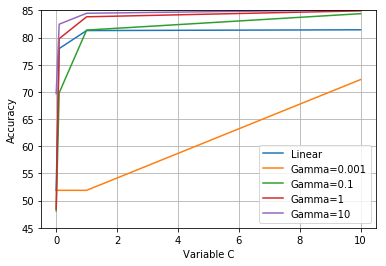


Neural Network:
TensorFlow version:1.12.0, Keras version:2.1.6-tf



In [17]:
#1.A Read Galaxy features (name of file, path, n_split, test size, random state)
if os.path.isfile(MERGED_GALAXY_PRIMITIVE):
    features, features_SVM, answers, dataset_splitter = Data.prepareDataset("Galaxy", MERGED_GALAXY_PRIMITIVE, 5, 0.2, 0)
else:
    features, features_SVM, answers, dataset_splitter = Data.prepareDataset("Galaxy", ALL_GALAXY_PRIMITIVE, 5, 0.2, 0)

    
#2. Algorithms
print("ALGORITHMS")
print("\nSVM:")
svm()

print("\nNeural Network:")
print("TensorFlow version:" + tf.VERSION + ", Keras version:" + tf.keras.__version__ + "\n")
# Diff number of layer
neuralNetwork(1, [100, 100, 2], 60, 0.0005)
neuralNetwork(2, [100, 2], 60, 0.0005)
neuralNetwork(3, [100, 100, 100, 100, 2], 60, 0.0005)
# Diff perceptron
neuralNetwork(4, [80, 50, 2], 60, 0.0005)
neuralNetwork(5, [120, 2], 60, 0.0005)
neuralNetwork(6, [100, 120, 100, 50, 2], 60, 0.0005)
# Diff epoch
neuralNetwork(7, [100, 100, 2], 60, 0.0005)
neuralNetwork(8, [100, 2], 20, 0.0005)
neuralNetwork(9, [100, 100, 100, 100, 2], 100, 0.0005)
# Diff learning
neuralNetwork(10, [100, 100, 2], 60, 0.0005)
neuralNetwork(11, [100, 2], 60, 0.005)
neuralNetwork(12, [100, 100, 100, 100, 2], 60, 0.05)

REMOVE NEXT CELL IN FINAL VERSION

In [ ]:
ALGORITHMS

SVM:
SVM linear
  Variable C  class_weight= {‘balanced’}
------------  ----------------------------
       0.001  51.89%
       0.1    77.97%
       1      81.28%
      10      81.43%
The best parameters are  {'C': 10.0, 'cache_size': 2048, 'class_weight': 'balanced', 'kernel': 'linear'}  with a score of 81.43%

SVM rbf
  Variable C  Ɣ=0.001    Ɣ=0.1    Ɣ=1.0    Ɣ=10.0
------------  ---------  -------  -------  --------
       0.001  51.89%     51.89%   51.89%   72.26%
       0.1    48.11%     69.83%   81.37%   84.39%
       1      48.46%     79.79%   83.81%   84.91%
      10      69.69%     82.45%   84.46%   85.10%
The best parameters are  {'C': 10.0, 'cache_size': 2048, 'class_weight': 'balanced', 'gamma': 10.0, 'kernel': 'rbf'}  with a score of 85.10%
-> Done


## Introduction



## Question 1 
### Présentation de la méthode de validation

## Question 2
### Présentation de la méthode de normalisation

## Question 3
### Description du réseau de neuronnes

## Question 4
### Analyse du réseau de neuronnes grace aux graphiques TensorBoard

## Question 5
### Score F1 et impact des hyperparamètres sur le réseau de neuronnes

## Question 6
### Méthode d'optimisation du modèle SVM

## Question 7
### Impact de la taille de l'ensemble d'apprentissage

## Question 8
### Formulation des recommandations

## Question 9
### Améliorations possibles

## Conclusion